# Basic Artificial Neural Networks

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib
from imp import reload

%matplotlib inline
matplotlib.style.use('ggplot')

# Toy example

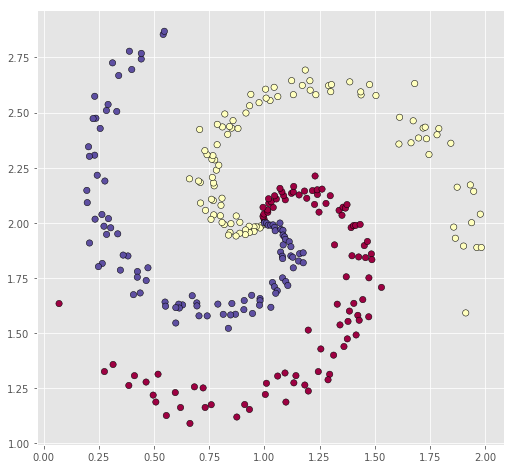

In [2]:
########################
# MORE COMPLEX 2D DATA #
########################

N = 100 # number of points per class
D = 2 # dimensionality
p = 4 # polynomial degree
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
X[:, 0] += 1
X[:, 1] += 2
# lets visualize the data:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors="black")
ax = plt.gca()
ax.set_aspect("equal")
plt.show()
import pandas as pd
Y = np.array(pd.get_dummies(y)).astype(int)

**simple nn** for debugging. 

In [3]:
import neural_network as nn
reload(nn);

In [13]:
criterion = nn.MSECriterion()

net = nn.Sequential()
net.add(nn.Linear(2, 10))

net.add(nn.ReLU())
net.add(nn.Linear(10,20))

net.add(nn.ReLU())
net.add(nn.Linear(20,3))
net.add(nn.SoftMax())

optimizer = nn.SGDMomentum(learning_rate=0.005, momentum=0.5)
n_epoch = 600
batch_size = 100

print(net)

Linear 2 -> 10
ReLU
Linear 10 -> 20
ReLU
Linear 20 -> 3
SoftMax



In [14]:
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

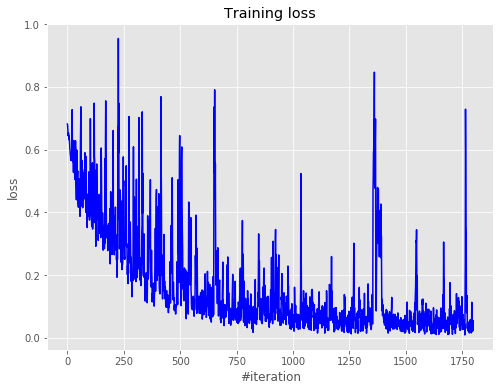

Current loss: 0.054565


In [15]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        optimizer.step(net.getParameters(), net.getGradParameters())
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

Now visualise class boundaries

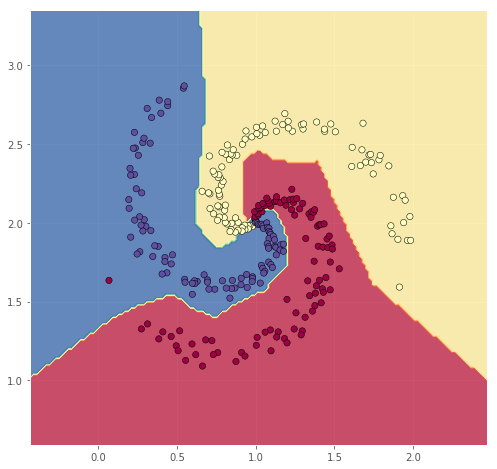

In [16]:
h = 0.02

x_min = X[:, 0].min() - 0.5
x_max =  X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
X0, Y0 = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

X0flat = X0.reshape(-1)
Y0flat = Y0.flatten()

X1 = np.stack([X0flat, Y0flat]).T

c = np.argmax(net.forward(X1), axis=-1).reshape(X0.shape)

c.shape

plt.figure(figsize=(10,8))
plt.contourf(X0, Y0, c, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors="black")
plt.xlim(X0.min(), X0.max())
plt.ylim(Y0.min(), Y0.max())
plt.gca().set_aspect("equal")
plt.show()

# Digit classification 

In [17]:
import os
from sklearn.datasets import fetch_openml
import numpy as np

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml("mnist_784")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [31]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
one_hot_y = enc.fit_transform(y.reshape(-1, 1)).todense()

x_flat = X.reshape(-1, 784)



/home/yeva/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [29]:
criterion1 = nn.MSECriterion()

net1= nn.Sequential()
net1.add(nn.Linear(784, 200))
net1.add(nn.ReLU())
net1.add(nn.Linear(200,60))
net1.add(nn.ReLU())
net1.add(nn.Linear(60,10))
net1.add(nn.SoftMax())

optimizer1 = nn.SGDMomentum(learning_rate=0.005, momentum=0.5)
n_epoch1 = 600
batch_size1 = 100

print(net1)

Linear 784 -> 200
ReLU
Linear 200 -> 60
ReLU
Linear 60 -> 10
SoftMax



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
loss_history = []

for i in range(n_epoch1):
    for x_batch, y_batch in get_batches(x_flat, one_hot_y, batch_size1):
        net1.zeroGradParameters()
        
        # Forward
        predictions = net1.forward(x_batch)
        loss = criterion1.forward(predictions, y_batch)
    
        # Backward
        dp = criterion1.backward(predictions, y_batch)
        net1.backward(x_batch, dp)
        
        # Update weights
        optimizer1.step(net1.getParameters(), net1.getGradParameters())
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

ValueError: shapes (100,10) and (100,10) not aligned: 10 (dim 1) != 100 (dim 0)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

Print here your accuracy. It should be around 90%.

# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it, but it is easy and extremely interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](img/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [ ]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [ ]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

# Experiments (interesting) 

* Use ANN with one hidden layer for simple 1d regression problem (generate random points and fit your model on it).
Compare **Tanh** and **ReLu** activations for hidden layer (note that you do not need any nonlinearity for output layer). Also tweak hidden layer size.

* Train a multilayer model on MNIST and reach ~95% accuracy on test set. Now randomly remove neurons from your network (i.e. set neuron parameters zero). Plot test set accuracy versus number of neurons removed. Do the same expeiment with 1) Dropout layer added, 2) BatchMeanSubtraction layer added.

* Train a model on MNIST with multiclass criterion. Now backpropagate label throw network, i.e. find the input that would produce given output. Your label was one-hot-encoded (only one digit was on the picture). This time backpropagate label, which has 2 or more ones and see the input picture of the network.